# Gradio Demo

In [37]:
import gradio as gr
from datetime import date
import torch
from fabric.generator import AttentionBasedGenerator
from fabric.utils import get_free_gpu, tile_images
import os
import re
import torchvision.transforms as T
from PIL import Image

In [38]:
ctx = {
    "model_version": "1.5",
    "model_name": "dreamlike-art/dreamlike-photoreal-2.0",
    "negative_prompt": "lowres, bad anatomy, bad hands, cropped, worst quality",
    "sample_prompt": "yes",
    "n_images": 4,
    "n_rounds": 3,
    "guidance_scale": 6,
    "denoising_steps": 1,
    "feedback": {
        "start": 0.0,
        "end": 1.0,
        "min_weight": 0.1,
        "max_weight": 0.8,
        "neg_scale": 0.5,
    },
    "global_seed": 0,
    "image_seed": None,
    "liked_images": [],
    "disliked_images": [],
    "output_path": "outputs/preference_model_feedback",
    "lora_weights": None,  # set to the path of the weights file if you have it
}


# Initialize images list
images = []

# Setup the model
model_name = "dreamlike-art/dreamlike-photoreal-2.0"
dtype = torch.float16 if torch.cuda.is_available() else torch.float32
device = "cpu"  # "mps" if torch.backends.mps.is_available() else "cpu"
device = get_free_gpu() if torch.cuda.is_available() else device
generator = AttentionBasedGenerator(
    model_name=model_name,
    torch_dtype=dtype,
).to(device)

### Functions 

In [39]:
def convert_tensor_to_image(tensor):
    tensor = tensor.detach().cpu()
    tensor = tensor.add(1).div(2)  # denormalize
    tensor = tensor.mul(255).byte()  # to [0, 255]
    tensor = tensor.permute(1, 2, 0)  # from CxHxW to HxWxC
    return Image.fromarray(tensor.numpy())


def store_text(input_text):
    global user_input
    user_input = input_text
    return f"You entered: {input_text}"


def gradio_generate_images(prompt, negative_prompt):
    # Generate a batch of images
    images_tensor = generate_images(prompt, negative_prompt, [], [])

    # Convert the tensor images to a format that Gradio can display
    images = [convert_tensor_to_image(img) for img in images_tensor]

    # Pair each image with a checkbox
    image_checkbox_pairs = [(img, False) for img in images]

    return image_checkbox_pairs


def generate_images(
    prompt,
    negative_prompt="",
    liked=[],
    disliked=[],
    model_ckpt=None,
    model_name=None,
    model_version=None,
    denoising_steps=20,
    guidance_scale=6,
    n_images=4,
    feedback_start=0.0,
    feedback_end=1.0,
    min_weight=0.1,
    max_weight=0.8,
    neg_scale=0.5,
    seed=0,
):
    dtype = torch.float16 if torch.cuda.is_available() else torch.float32
    device = get_free_gpu() if torch.cuda.is_available() else "cpu"

    # Initialize the generator
    generator = AttentionBasedGenerator(
        model_ckpt=model_ckpt,
        model_name=model_name,
        stable_diffusion_version=model_name,
        torch_dtype=dtype,
    ).to(device)

    # Generate images
    images = generator.generate(
        prompt=prompt,
        negative_prompt=negative_prompt,
        liked=liked,
        disliked=disliked,
        seed=seed,
        n_images=n_images,
        guidance_scale=guidance_scale,
        denoising_steps=denoising_steps,
        feedback_start=feedback_start,
        feedback_end=feedback_end,
        min_weight=min_weight,
        max_weight=max_weight,
        neg_scale=neg_scale,
    )

    return images

### 1. Read user Prompt

In [40]:
import gradio as gr

# This variable will store the user input
user_input = None

iface = gr.Interface(
    fn=store_text,
    inputs=gr.inputs.Textbox(lines=2, placeholder="Enter prompt here..."),
    outputs="text",
)

iface.launch()

/var/folders/hg/k29n8l193w76mcsdz5qf1w5h0000gn/T/ipykernel_38354/2688693426.py:8: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs=gr.inputs.Textbox(lines=2, placeholder="Enter prompt here..."),
/var/folders/hg/k29n8l193w76mcsdz5qf1w5h0000gn/T/ipykernel_38354/2688693426.py:8: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Textbox(lines=2, placeholder="Enter prompt here..."),
/var/folders/hg/k29n8l193w76mcsdz5qf1w5h0000gn/T/ipykernel_38354/2688693426.py:8: GradioDeprecationWarning: `numeric` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Textbox(lines=2, placeholder="Enter prompt here..."),


Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


In [43]:
# After submitting text in the Gradio interface, you can print the user_input variable
print(user_input)

hello


### 2. Generate batch of images without feedback (yet)

In [44]:
imgs = generate_images(
    prompt=user_input,
    negative_prompt=ctx["negative_prompt"],
    liked=[],
    disliked=[],
    model_ckpt=None,
    model_name=ctx["model_name"],
    model_version=ctx["model_version"],
    denoising_steps=ctx["denoising_steps"],
    guidance_scale=ctx["guidance_scale"],
    n_images=ctx["n_images"],
    feedback_start=ctx["feedback"]["start"],
    feedback_end=ctx["feedback"]["end"],
    min_weight=ctx["feedback"]["min_weight"],
    max_weight=ctx["feedback"]["max_weight"],
    neg_scale=ctx["feedback"]["neg_scale"],
    seed=ctx["global_seed"],
)

100%|██████████| 1/1 [00:24<00:00, 24.24s/it]
/opt/homebrew/Caskroom/miniforge/base/envs/fabric/lib/python3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:471: FutureWarning: The decode_latents method is deprecated and will be removed in a future version. Please use VaeImageProcessor instead
  warnings.warn(


#### Show first batch 

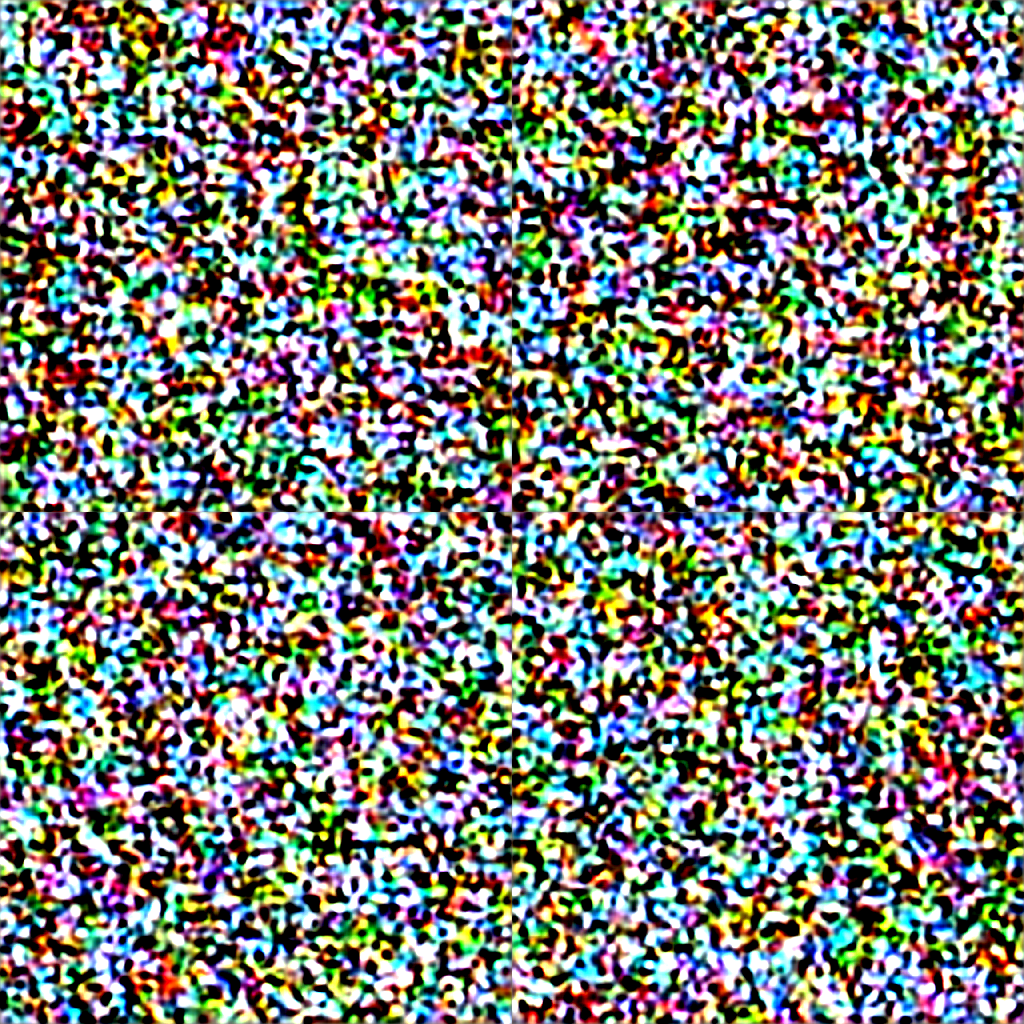

In [60]:
# display the PIL imges in 2x2 grid

tile_images(imgs)

### 3. Feedback time !

In [61]:
import gradio as gr

liked_indices = []
not_liked_indices = []


def collect_feedback(liked, not_liked):
    global liked_indices, not_liked_indices
    liked_indices = liked
    not_liked_indices = not_liked
    return "Feedback collected"


checkbox_choices = [str(i) for i in range(4)]
liked_checkboxes = [gr.inputs.CheckboxGroup(checkbox_choices, label="Liked Images")]
not_liked_checkboxes = [
    gr.inputs.CheckboxGroup(checkbox_choices, label="Not Liked Images")
]

interface = gr.Interface(
    fn=collect_feedback,
    inputs=liked_checkboxes + not_liked_checkboxes,
    outputs="text",
    examples=[[0, 1], [2, 3], [1, 3], [0, 2]],  # Example inputs for the checkboxes
)

interface.launch()

/var/folders/hg/k29n8l193w76mcsdz5qf1w5h0000gn/T/ipykernel_38354/3295751262.py:13: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  liked_checkboxes = [gr.inputs.CheckboxGroup(checkbox_choices, label="Liked Images")]
/var/folders/hg/k29n8l193w76mcsdz5qf1w5h0000gn/T/ipykernel_38354/3295751262.py:13: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  liked_checkboxes = [gr.inputs.CheckboxGroup(checkbox_choices, label="Liked Images")]
/var/folders/hg/k29n8l193w76mcsdz5qf1w5h0000gn/T/ipykernel_38354/3295751262.py:14: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  not_liked_checkboxes = [gr.inputs.CheckboxGroup(checkbox_choices, label="Not Liked Images")]
/var/folders/hg/k29n8l193w76mcsdz5qf1w5h0000gn/T/ipykernel_38354/3295751262.py:14: Gr

Running on local URL:  http://127.0.0.1:7870

To create a public link, set `share=True` in `launch()`.


In [64]:
liked_indices, not_liked_indices

(['0'], ['1', '2'])

### 4. Generate new batch!

In [66]:
liked_images = [imgs[int(i)] for i in liked_indices]
not_liked_images = [imgs[int(i)] for i in not_liked_indices]

In [67]:
imgs = generate_images(
    prompt=user_input,
    negative_prompt=ctx["negative_prompt"],
    liked=liked_images,
    disliked=not_liked_images,
    model_ckpt=None,
    model_name=ctx["model_name"],
    model_version=ctx["model_version"],
    denoising_steps=ctx["denoising_steps"],
    guidance_scale=ctx["guidance_scale"],
    n_images=ctx["n_images"],
    feedback_start=ctx["feedback"]["start"],
    feedback_end=ctx["feedback"]["end"],
    min_weight=ctx["feedback"]["min_weight"],
    max_weight=ctx["feedback"]["max_weight"],
    neg_scale=ctx["feedback"]["neg_scale"],
    seed=ctx["global_seed"],
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# display the PIL imges in 2x2 grid

tile_images(imgs)